1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import poisson,norm,t
from scipy import fftpack
from matplotlib.colors import LogNorm

In [17]:
#mean and variance are the same for the poisson distribution
n = 15
mu = var = 6.3
Z = 3

#computing the probility suggested in the hint
PP = 1 - poisson.cdf(n,mu)
print('PP:', PP)

#computing the probability that a sample drawn from a normal distribution is more extreme than Z = 3 
PN = norm.cdf(-Z) + (1. - norm.cdf(Z))
print('PN:', PN)

print('\nNULL HYPOTESIS: 15 hurricanes is significantly different from the mean')
if PP>PN:
    print('FALSE')
else:
    print('TRUE')

PP: 0.0008444930803583883
PN: 0.0026997960632601965

NULL HYPOTESIS: 15 hurricanes is significantly different from the mean
TRUE


2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In [18]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
n = len(pre)

sig = np.sqrt(0.5 * (np.var(pre) + np.var(post)))
T = (np.mean(pre) - np.mean(post))/(sig * np.sqrt(2/n))
pvalue = t.cdf(T, n - 1) + (1. - t.cdf(-T, n - 1))

print('pvalue:',pvalue,'\n')
if pvalue > 0.1: print('significant change') #I use 0.1 as threshold value
else: print('NON significant change')

pvalue: 0.0031489409354536393 

NON significant change


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

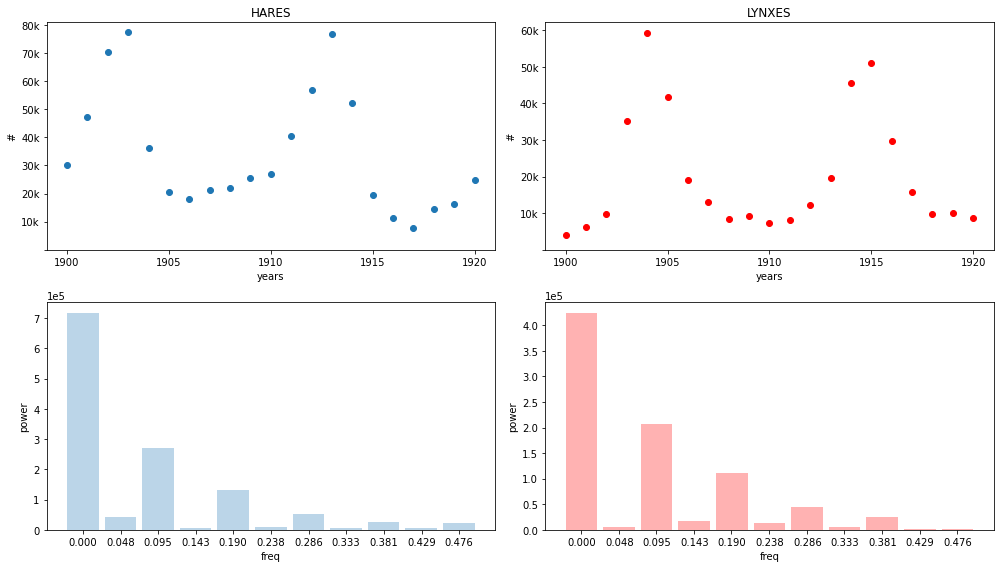

In [41]:
data = np.loadtxt('populations.txt')
year, hares, lynxes, carrots = data.T

h_fft = fftpack.fft(hares)
l_fft =  fftpack.fft(lynxes)

sample_freq = fftpack.fftfreq(len(year), d=1)

mask = sample_freq>=0 

sample_freq = sample_freq[mask]
h_powers = abs(h_fft)[mask]
l_powers = abs(l_fft)[mask]

fig, (ax1,ax2) = plt.subplots(ncols=2, nrows = 2, figsize = (14,8))

ax1[0].scatter(year,hares)
ax1[1].scatter(year,lynxes, color = 'r')
ax2[0].bar(sample_freq,h_powers,width = 0.04,alpha = 0.3)
ax2[1].bar(sample_freq,l_powers,width = 0.04,alpha = 0.3, color = 'r')

ax1[0].title.set_text('HARES')
ax1[1].title.set_text('LYNXES')

ax1[0].set_xlabel('years')
ax1[1].set_xlabel('years')
ax2[0].set_xlabel('freq')
ax2[1].set_xlabel('freq')

ax1[0].set_ylabel('#')
ax1[1].set_ylabel('#')
ax2[0].set_ylabel('power')
ax2[1].set_ylabel('power')

bin_centres = np.around(sample_freq, decimals = 3)
x_ticks = np.arange(min(year), max(year) + 5, 5)
h_y_ticks = np.arange(0,90000,10000)
l_y_ticks = np.arange(0,70000,10000)
label_h = ['','10k','20k','30k','40k','50k','60k','70k','80k']
label_l = ['','10k','20k','30k','40k','50k','60k']
ax1[0].set_xticks(x_ticks)
ax1[1].set_xticks(x_ticks)
ax1[0].set_yticks(h_y_ticks)
ax1[1].set_yticks(l_y_ticks)
ax1[0].set_yticklabels(label_h)
ax1[1].set_yticklabels(label_l)
ax2[0].set_xticks(bin_centres)
ax2[1].set_xticks(bin_centres)
ax2[0].ticklabel_format(axis = 'y', style = 'scientific', scilimits = (0,0))
ax2[1].ticklabel_format(axis = 'y', style = 'scientific', scilimits = (0,0))

plt.tight_layout()
plt.show()

#There is not a real period for these two populations and the main frequence for both is around 0.095 1/year,
#not considering the offset

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

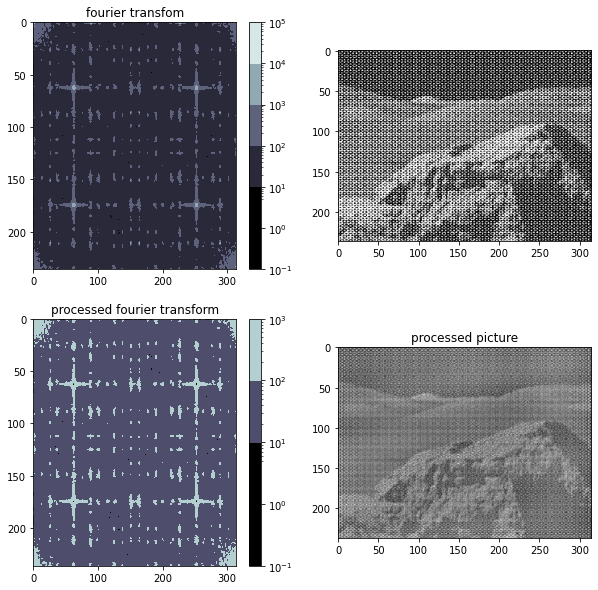

In [9]:
im = plt.imread("C://Users/Luca/data/moonlanding_small.png")

#Fourier transform
sig = fftpack.fft2(im)
power = abs(sig)

#Cutting noise, hopefully.
sig_m = sig.copy()
power_m = power.copy()
power_m[power_m > 1e3] = 1e-1
sig_m[power > 1e3] = 0

#inverse fourier transform
im_m = fftpack.ifft2(sig_m)
im_m = np.real(im_m)

#showing the initial picture, the ft, the masked ft and the processed picture
x = np.arange(0,im.shape[0], 1)
y = np.arange(0,im.shape[1], 1)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
cs1 = ax1.contourf(y,x,power, cmap=plt.cm.bone, norm = LogNorm(vmin=5))
ax1.title.set_text('fourier transfom')
ax1.invert_yaxis()
cbar1 = fig.colorbar(cs1, orientation = 'vertical', pad = 0.05, ax = ax1)
ax2.imshow(im, cmap = 'gray')
ax3.invert_yaxis()
ax3.title.set_text('processed fourier transform')
cs3 = ax3.contourf(y, x,power_m, cmap = plt.cm.bone, norm = LogNorm(vmin= 5))# AGGIUNTA
cbar3 = fig.colorbar(cs3, orientation = 'vertical', pad = 0.05, ax = ax3)
ax4.imshow(im_m, cmap = 'gray')
ax4.title.set_text('processed picture')
plt.show()

#Actually I couldn't